<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-предпросмотр" data-toc-modified-id="Загрузка-данных-и-предпросмотр-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных и предпросмотр</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

**Импорт библиотек:**

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 

pd.set_option('display.max_colwidth', None)

## Подготовка

### Загрузка данных и предпросмотр

In [2]:
 try:
        df = pd.read_csv('taxi.csv')
 except FileNotFoundError:
        df = pd.read_csv('datasets/taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Таблицу успешно считали в датафрейм, теперь посмотрим информацию о ней.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Полученный датасет состоит из 26496 наблюдений. Включает два признака, один целевой - `num_orders` и информацию о временном отрезке. Причем тип данных *object* нам не подходит, преобразуем его в датовый тип.

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Теперь с типом данных все в порядке, и мы можем работать со временем. Отметим, что таблица не содерижт пропусков.

Для упрощение работы с временным рядом приравняем столбец с датой с индексем таблицы:

In [5]:
df.set_index('datetime', inplace=True)
df.head(2)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14


Посмотрим все ли даты идут друг за другом:

In [6]:
df.index.is_monotonic_increasing

True

Проверим, есть ли дублирующие даты. Т.к. даты у нас теперь в индексе таблицы, то и дубли будем там искать: 

In [7]:
df[df.index.duplicated()]

,num_orders
datetime,


Из первых строк можно заметить, что периодичность записей составляет 10 минут, проверим является ли она постоянной:

In [8]:
df.index.to_series().diff().value_counts()

datetime
0 days 00:10:00    26495
Name: count, dtype: int64

**Вывод:**

Исходные данные представляют собой таблицу, содержащую 26496 строк и два признака: целевой `num_orders` и входной `datetime`. Исправили тип данных временного признака на *datetime* и приравняли его к индексу таблицы. Временной ряд монотонно возрастает, не имеет пропусков или дубликатов, периодичность составляет 10 минут на протяжении всего датасета. Данные готовы к этапу анализа.

## Анализ

Перед началом анализа изменим интервал между записями с 10 минут до 1 часа, т.к. прогноз требуется совершить именно для этого периода:

In [9]:
df = df.resample('1h').sum()

Посмотрим на статистику количества такси за 1 час:

In [10]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


В среднем по 84 машин вызывают каждый час, но бывает и такое, что никто не обратился или, напротив, огромный наплыв клиентов до 462 заказов такси. 

In [11]:
print(f'Первая дата: {df.index.min()}')
print(f'Последняя дата: {df.index.max()}')

Первая дата: 2018-03-01 00:00:00
Последняя дата: 2018-08-31 23:00:00


Наблюдения проводились в течении полугода с начала марта по конец августа, и затрагивают весенний и летний периоды. Построим график за весь период наблюдений:

In [12]:
def make_plot(df):
    plt.figure(figsize=(20,7))
    plt.plot(df.index, df['num_orders'], linewidth=2)
    plt.xlabel('Временной ряд',  fontsize=16)
    plt.ylabel('Количество машин',  fontsize=16)
    plt.grid()

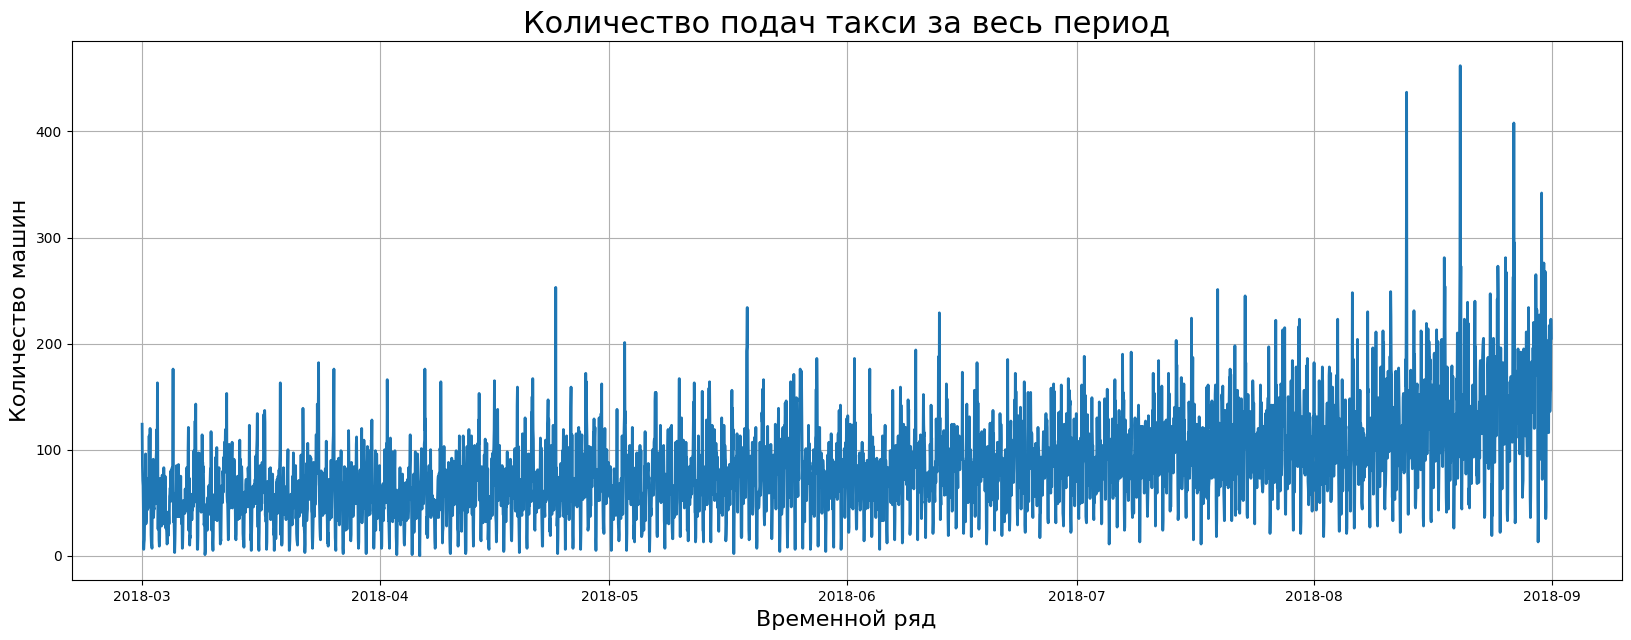

In [13]:
make_plot(df)
plt.title('Количество подач такси за весь период', fontsize=22)
plt.show()

На графике видим большое число колебаний. Из общей картины можно сделать вывод, что к концу лета спрос на такси возрос. Связано это с трендом или с сезонностью пока непонятно. Для снижения колебаний применим метод скользящего среднего. Подберем подходящее окно для него. Рассмотрим следующие варианты: 4, 24, 7 * 24, т.о, сможем уловить закономерности в течении дня/недели/месяца.

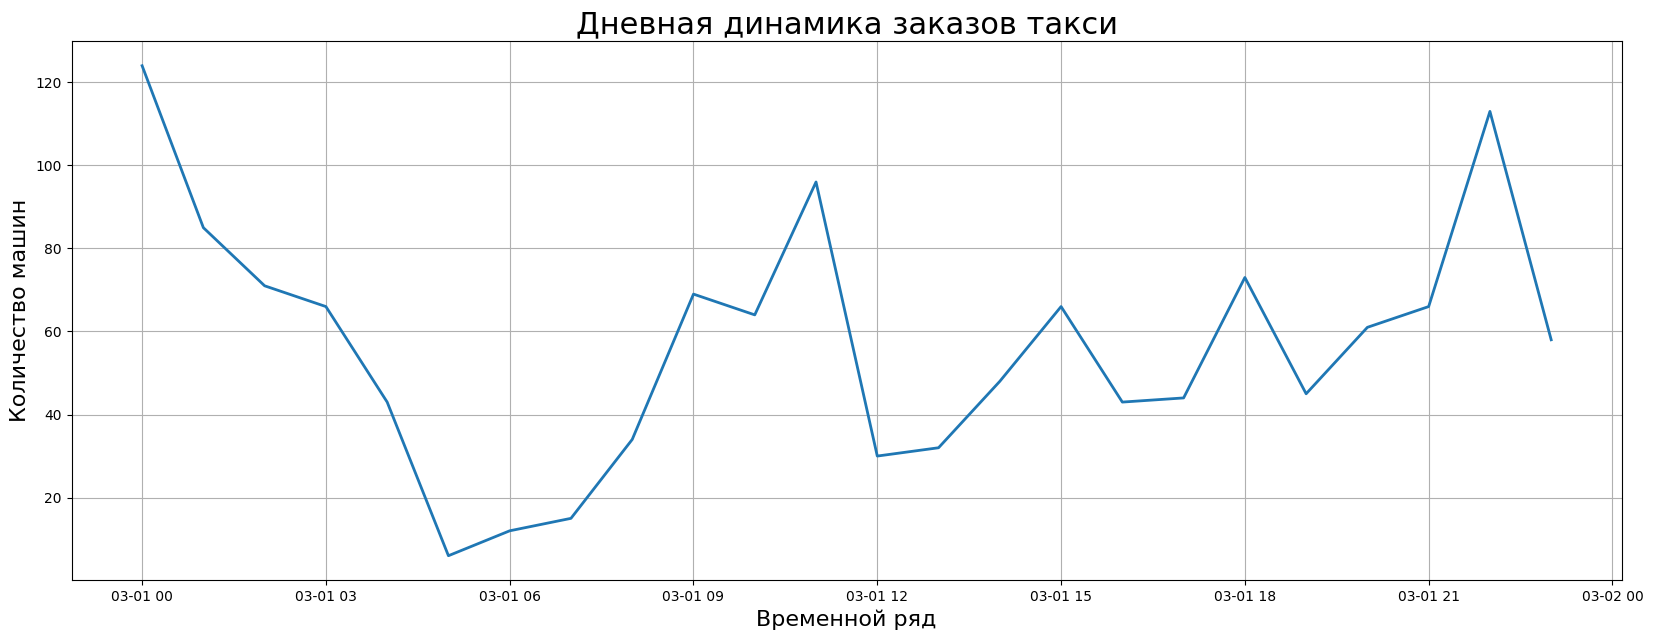

In [14]:
make_plot(df.loc['2018-03-01'])
plt.title('Дневная динамика заказов такси', fontsize=22)
plt.show()

Динамика в течении дня: в ночные часы после полуночи количество заказов снижается, рано утром около шести часов рост возобновляется, в полдень падает до определенного уровня и сохраняется так до позднего вечера. После девяти вечера снова наблюдается рост до максимальных величин. Это всего один день, причем будний, в выходные будем наблюдать другую динамику. Посмотрим на изменение в течении недели: 

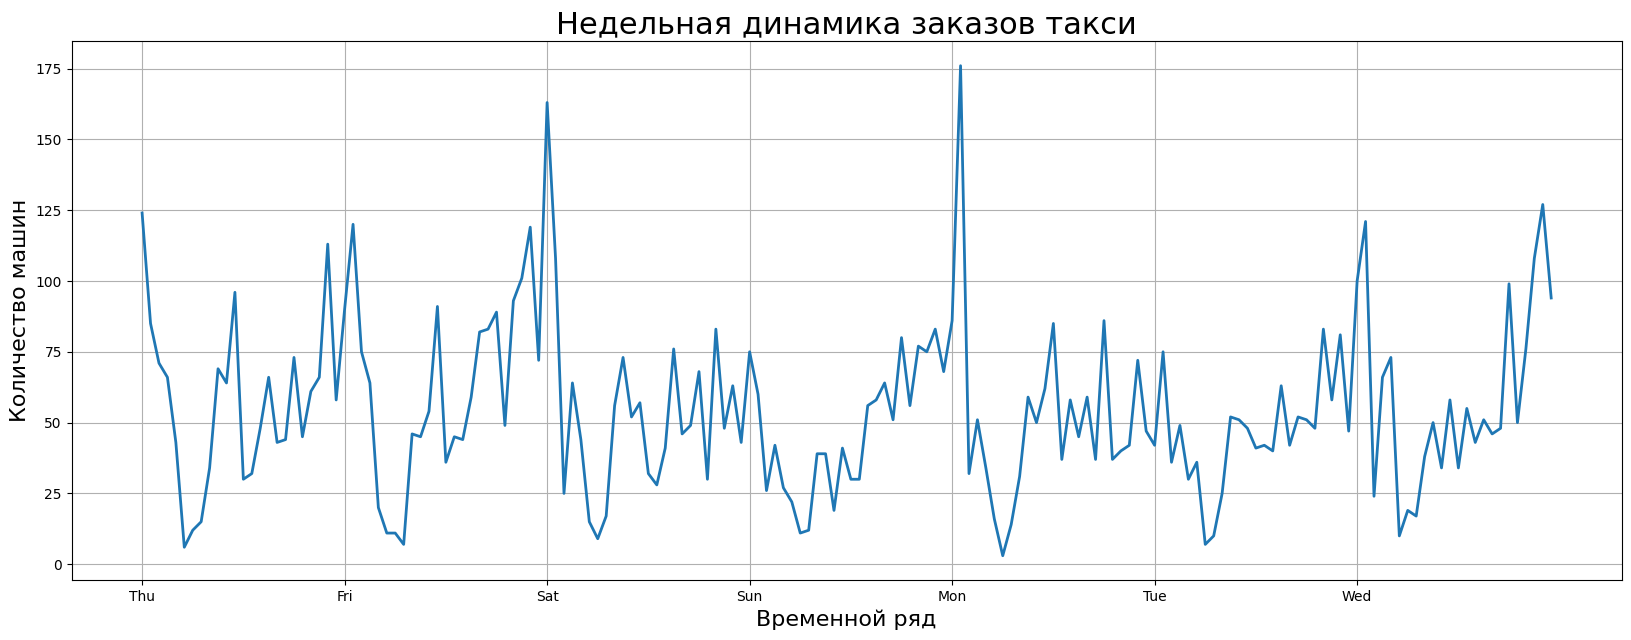

In [15]:
make_plot(df['2018-03-01':'2018-03-07'])
plt.title('Недельная динамика заказов такси', fontsize=22)
plt.xticks(df['2018-03-01':'2018-03-07'].resample('D').sum().index, 
           df['2018-03-01':'2018-03-07'].resample('D').sum().index.strftime('%a'))
plt.show()

Внутри одной недели изменение спроса на такси выглядит так: в начале недели - минимальный спрос, постепенно возрастает, к концу рабочей недели достигает пика среди будней. На выходных спрос падает до уровня понедельника и к концу воскресения резко возрастает до макисмума недели. Изучим динамику месяца, при этом сгладим колебания с помощью скользящего среднего 24-часового окна.

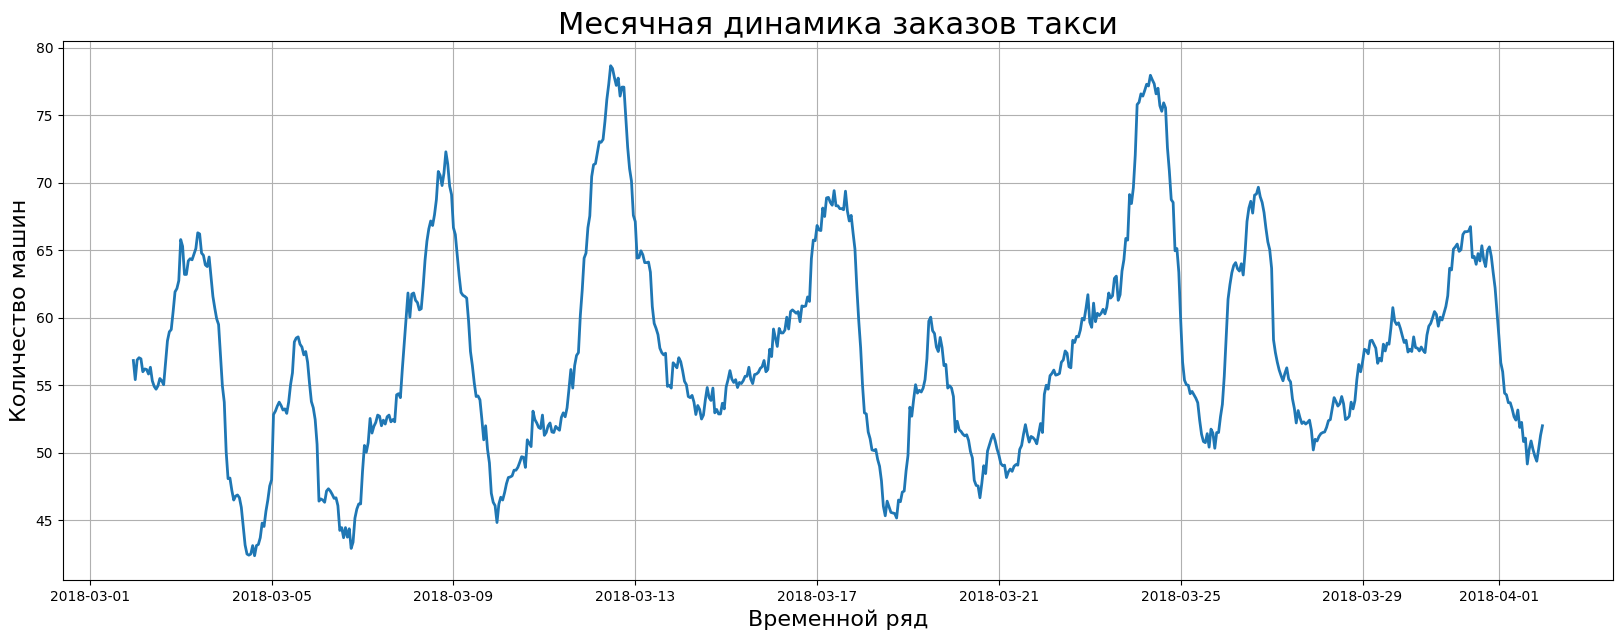

In [16]:
make_plot(df['2018-03-01':'2018-04-01'].rolling(24).mean())
plt.title('Месячная динамика заказов такси', fontsize=22)
plt.show()

В течении месяца мы наблюдаем повторяющиеся недельные паттерны. К концу месяца уровень локальных минимумов возрастает, т.о. количество авто практически не падает ниже 50 в последнюю неделю месяца. Чтобы понять, это колебание или признаки восходящего тренда, построим динамику за весь период наблюдения, но сглаженный еще большим окном.

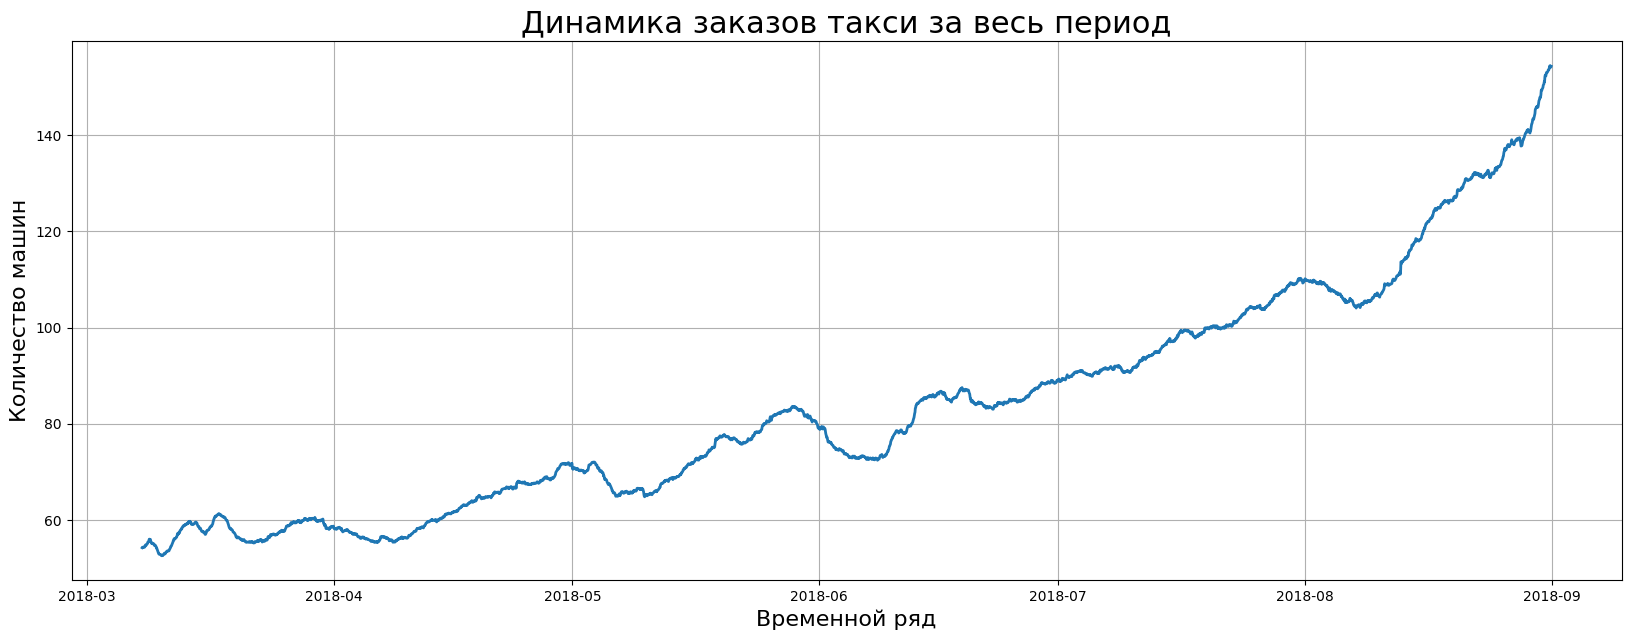

In [17]:
make_plot(df.rolling(7 * 24).mean())
plt.title('Динамика заказов такси за весь период', fontsize=22)
plt.show()

Сомнений нет, за весь период мы видим постоянный рост числа такси. В подтверждение всего вышесказанного воспользуемся инструментом *seasonal_decompose*, чтобы выделить из ряда тренд, сезонность и шум:

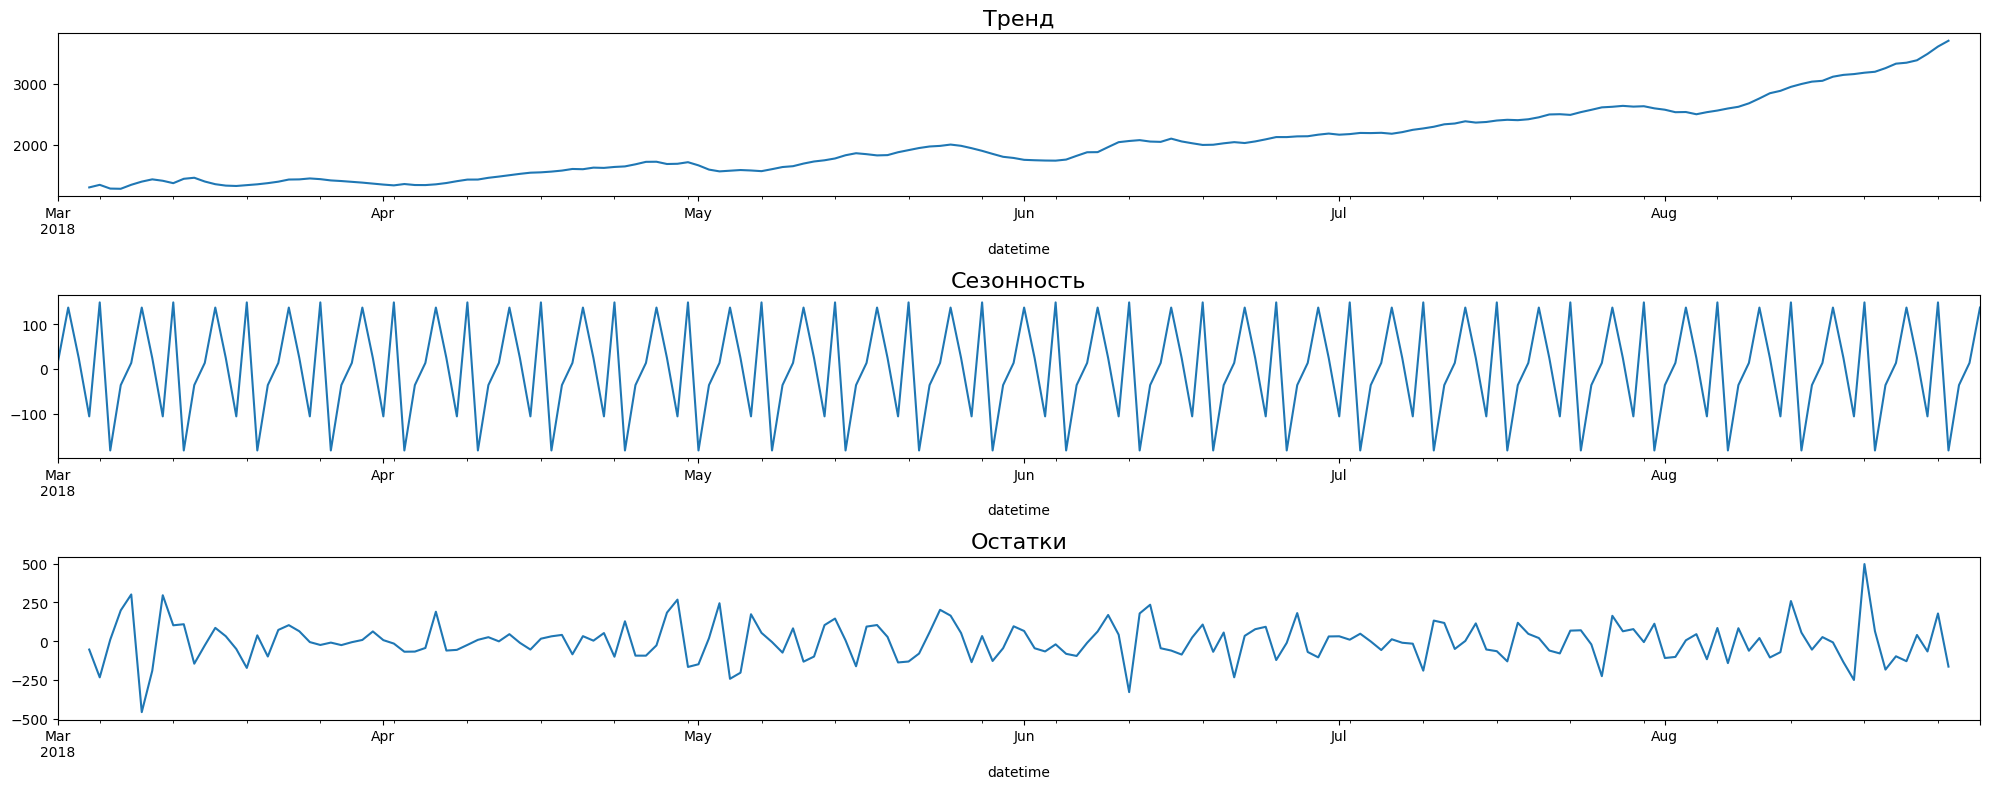

In [18]:
decomposed = seasonal_decompose(df.resample('1D').sum())

plt.figure(figsize=(20, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд', fontsize=16)

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность', fontsize=16)

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки', fontsize=16)

plt.tight_layout()
plt.show()

Во всем ряде наблюдаем восходящий тренд. Имеем недельную сезонность. В остатках находятся просто шумы, т.к. выделить последовательный паттерн нельзя.

Проверим временный ряд на стационарность для этого вычислим среднее и стандартное отклонение ряда и отобразим на графике:

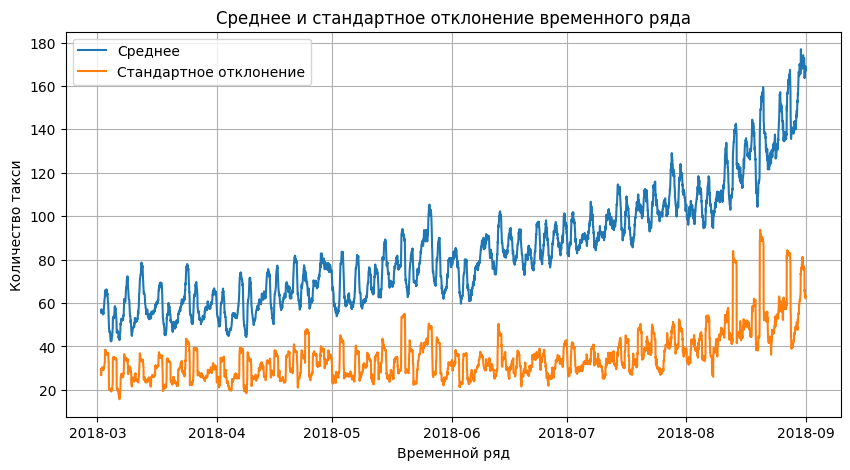

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(df.rolling(24).mean(), label='Среднее')
plt.plot(df.rolling(24).std(), label='Стандартное отклонение')
plt.legend()
plt.title('Среднее и стандартное отклонение временного ряда')
plt.xlabel('Временной ряд')
plt.ylabel('Количество такси')
plt.grid()
plt.show()

Среднее значение и отклонение повышаются со временем, поэтому ряд не является стационарным. Посмотрим, что изменится при смещении ряда:

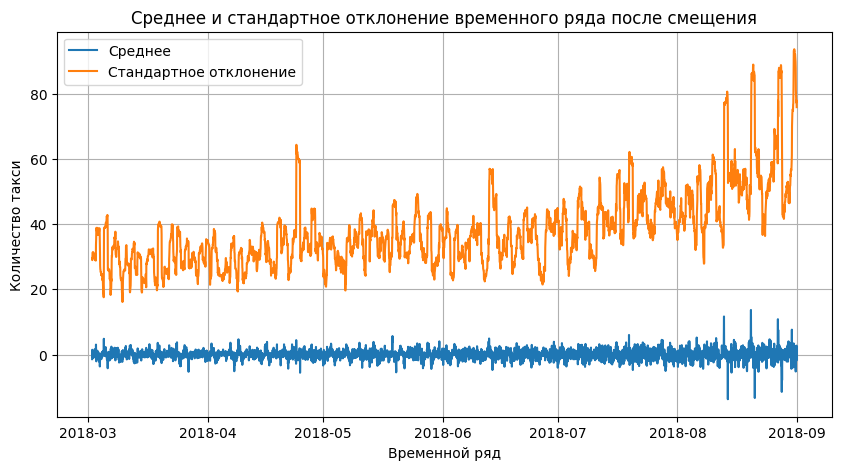

In [20]:
df_shifted = df - df.shift()

plt.figure(figsize=(10, 5))
plt.plot(df_shifted.rolling(24).mean(), label='Среднее')
plt.plot(df_shifted.rolling(24).std(), label='Стандартное отклонение')
plt.legend()
plt.title('Среднее и стандартное отклонение временного ряда после смещения')
plt.xlabel('Временной ряд')
plt.ylabel('Количество такси')
plt.grid()
plt.show()

Эта операция выровняла среднее ряда, но не отклонение.

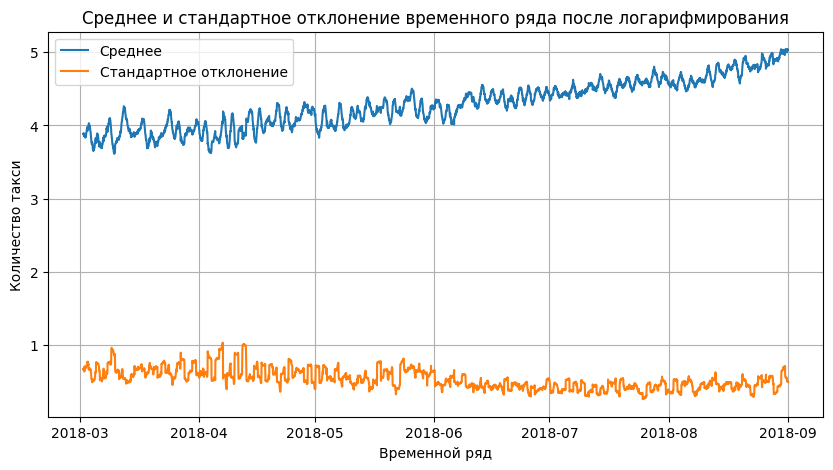

In [21]:
df_log = np.log1p(df)

plt.figure(figsize=(10, 5))
plt.plot(df_log.rolling(24).mean(), label='Среднее')
plt.plot(df_log.rolling(24).std(), label='Стандартное отклонение')
plt.legend()
plt.title('Среднее и стандартное отклонение временного ряда после логарифмирования')
plt.xlabel('Временной ряд')
plt.ylabel('Количество такси')
plt.grid()
plt.show()
# plt.plot(df_log.resample('1D').mean())
# plt.plot(df_log.rolling(24).mean(), label='mean')
# plt.plot(df_log.rolling(24).std(), label='std')

На этот раз раброс уменьшился и так сильно не изменяется, но остался рост среднего. Совместим обе операции и построим график:

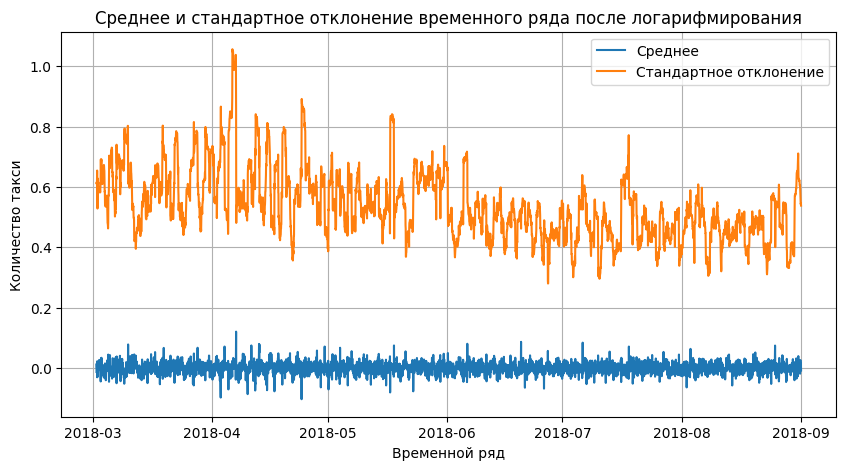

In [22]:
df_log_shifted = df_log - df_log.shift()

plt.figure(figsize=(10, 5))
plt.plot(df_log_shifted.rolling(24).mean(), label='Среднее')
plt.plot(df_log_shifted.rolling(24).std(), label='Стандартное отклонение')
plt.legend()
plt.title('Среднее и стандартное отклонение временного ряда после логарифмирования')
plt.xlabel('Временной ряд')
plt.ylabel('Количество такси')
plt.grid()
plt.show()

# plt.plot(df_log_shifted.resample('1D').sum())
# plt.plot(df_log_shifted.rolling(24).mean(), label='mean')
# plt.plot(df_log_shifted.rolling(24).std(), label='std')

Такой преобразованный ряд можно считать стационарным. Еще раз выделим тренд, сезонность и остатки на преобразованном ряду:

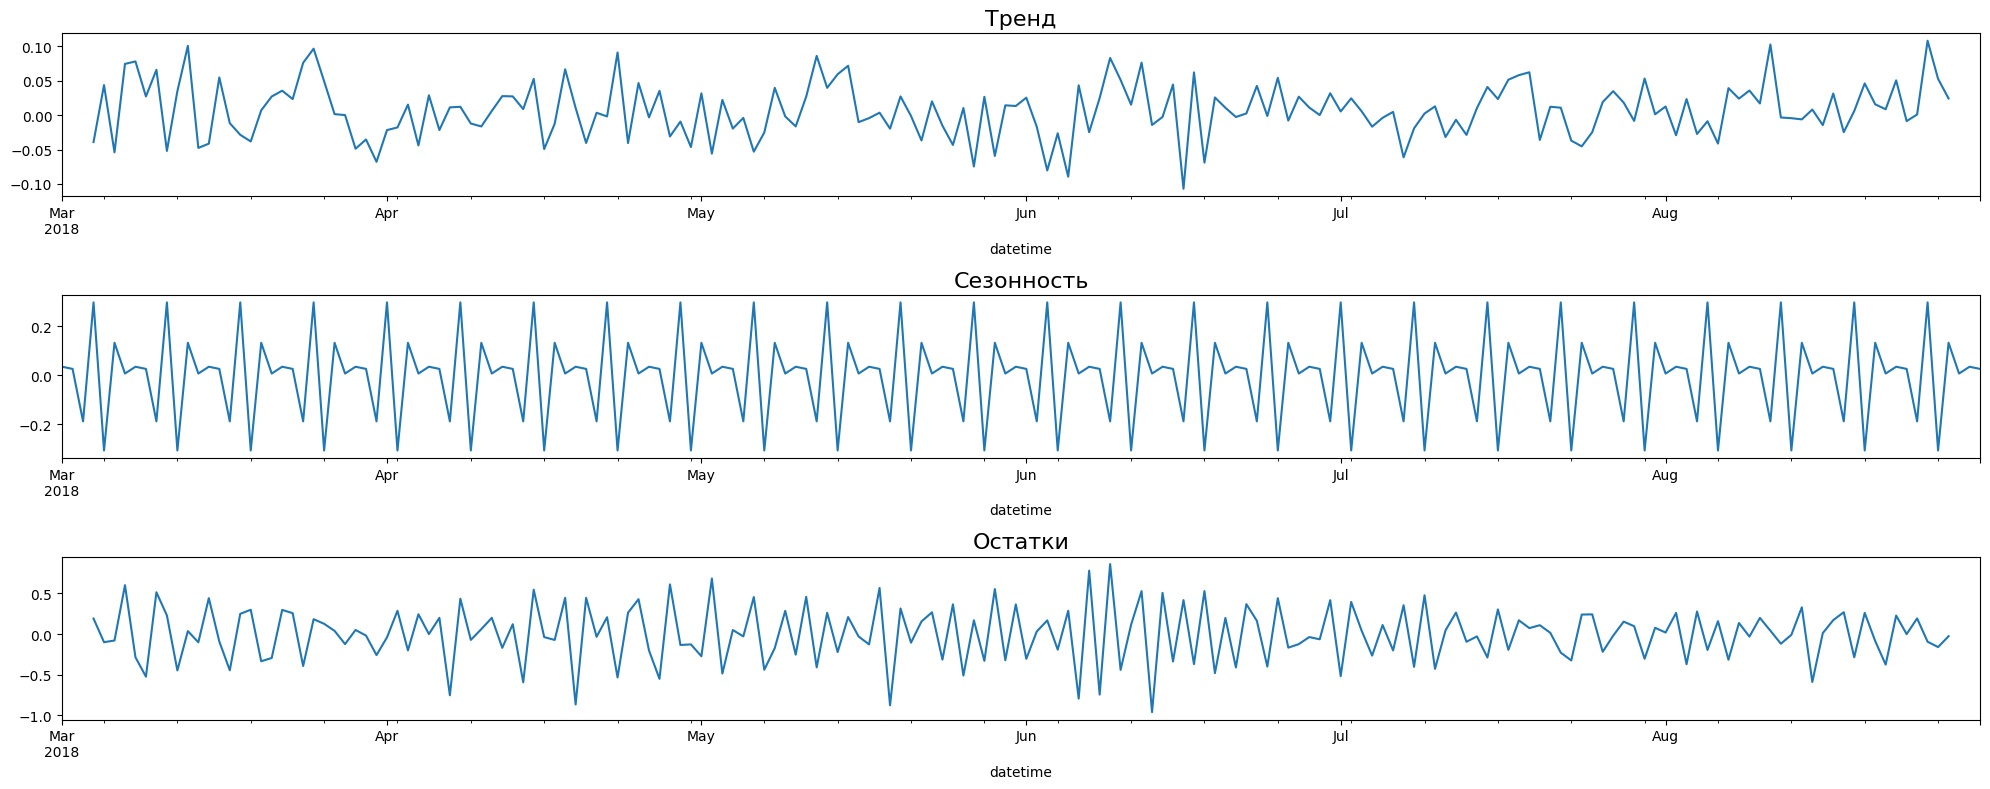

In [23]:
decomposed = seasonal_decompose(df_log_shifted.resample('1D').sum())

plt.figure(figsize=(20, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд', fontsize=16)

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность', fontsize=16)

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки', fontsize=16)

plt.tight_layout()
plt.show()

Теперь видим, что тренд исчез, а остатки представляют собой шум.

**Вывод:**

Датасет представляет наблюдения за полгода. Во временном ряду мы выделили: 
+ суточную сезонность: ночью заказов мало, днем умеренно, поздно вечером наблюдаем максимум;
+ недельную: в начале недели - минимум, максимумы находятся в конце рабочей недели и календарной.

Выделив тренд, показали, что временный ряд не является стационарным, т.к. среднее и стандартное отклонение постоянно растут со временем. Для того, чтобы ряд выровнять требуется провести логарфимизацию признака и сдвиг ряда. Данное наблюдение мы используем для создания новых признаков: лагов на основе отлагорифмированного таргета, а также скользящего среднего. 

## Обучение

Перед созданием новых признаков применим функцию логарифма к нашему таргету:

In [24]:
df['num_orders'] = np.log1p(df['num_orders'])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,4.828314
2018-03-01 01:00:00,4.454347
2018-03-01 02:00:00,4.276666
2018-03-01 03:00:00,4.204693
2018-03-01 04:00:00,3.784190


Теперь представим функцию, с помощью которой будем создавать новые признаки. Так присутствует суточная и недельная сезонность, то час и день недели мы должны знать. Добавим к этому списку новых признаков день и месяц, т.к. в работе такси в течении года (у нас период меньше, и мы не выявили) может наблюдаться сезонность в зависимости от месяца. Что касается количества лагов и размера скользящего среднего, то его мы подберем позже.

In [25]:
def make_features(data, max_lag, window_size):
    
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['month'] = data.index.month
    
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(window_size).mean()
    return data.dropna()

Создадим пайплайн для обработки новых признаков:

In [26]:
ord_columns = ['hour', 'day', 'day_of_week', 'month']

ord_pipe = Pipeline(
    [

        (
            'ord',
            OrdinalEncoder(
                categories=[
                    list(np.linspace(0, 23, 24)),
                    list(np.linspace(1, 31, 31)),
                    list(np.linspace(0, 6, 7)),
                    list(np.linspace(1, 12, 12)),
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessing', data_preprocessor),
        ('modeling', LinearRegression())
    ]
)

Теперь подберем параметры для функции *make_features*:

In [27]:
best_rmse = float('inf')
best_params = []

for max_lag in range(1, 25):
    for window_size in range(1, 49):
        data = make_features(df, max_lag, window_size)
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        X_train, y_train = train.drop('num_orders', axis=1), train['num_orders']
        X_test, y_test = test.drop('num_orders', axis=1), test['num_orders']
        
        pipe_final.fit(X_train, y_train)
        
        rmse = root_mean_squared_error(y_test, pipe_final.predict(X_test))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (max_lag, window_size)

print(f"Лучший RMSE: {best_rmse}")
print(f"Лучшие параметры (max_lag, window_size): {best_params}")

Лучший RMSE: 0.32139381756482316
Лучшие параметры (max_lag, window_size): (22, 24)


Лучшими параметрами является число лагов: 22, размер окна: 24. Создадим новые признаки и разделим на выборки:

In [28]:
data = make_features(df, 22, 24)
train, test = train_test_split(data,
                               shuffle=False, 
                               test_size=0.1)
train = train.dropna()
X_train, y_train = train.drop('num_orders', axis=1), train['num_orders']
X_test, y_test = test.drop('num_orders', axis=1), test['num_orders']

Подберем модель из четырех линейных: классическая LineraRegression, Ridge, Lasso и ElasticNet с возможностью уменьшать коэффициенты или занулять.

In [29]:
param_grid = [
    
    {
        'modeling': [Ridge()],
        'modeling__alpha': [0.01, 0.1, 0.5, 1], 
        'modeling__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg']
    },
    
    {
        'modeling': [Lasso()],
        'modeling__alpha': [0.01, 0.1, 0.5, 1]
        
    },
    
    {
        'modeling': [ElasticNet()],
        'modeling__alpha': [0.01, 0.1, 0.5, 1],
        'modeling__l1_ratio': [0.1, 0.5, 0.9]
    },
    
    {
        'modeling': [LinearRegression()]
    }
    
]

best_model = GridSearchCV(
    pipe_final, 
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',  
    n_jobs=-1
)

best_model.fit(X_train, y_train)

rmse = best_model.best_score_
print('Метрика RMSE для лучшей модели:\n', -rmse)

result = pd.DataFrame(best_model.cv_results_).sort_values('rank_test_score')
result[['rank_test_score', 'param_modeling', 'mean_test_score','params']].head(5)

Метрика RMSE для лучшей модели:
 0.3675114172131918


,rank_test_score,param_modeling,mean_test_score,params
20,1,ElasticNet(),-0.367511,"{'modeling': ElasticNet(), 'modeling__alpha': 0.01, 'modeling__l1_ratio': 0.1}"
14,2,Ridge(),-0.367985,"{'modeling': Ridge(), 'modeling__alpha': 1, 'modeling__solver': 'lsqr'}"
15,3,Ridge(),-0.367988,"{'modeling': Ridge(), 'modeling__alpha': 1, 'modeling__solver': 'sparse_cg'}"
13,4,Ridge(),-0.367989,"{'modeling': Ridge(), 'modeling__alpha': 1, 'modeling__solver': 'cholesky'}"
12,5,Ridge(),-0.367989,"{'modeling': Ridge(), 'modeling__alpha': 1, 'modeling__solver': 'svd'}"


Лучшей моделью стала ElasticNet. На показатели метрики пока не стоит смотреть, т.к. они выведены на логарифмированном таргете. Настало время проверить модель на тестовых данных и проанализировать остатки.

## Тестирование

Напишем функцию, которая наглядно покажет распределние и дисперсию остатков модели.

In [30]:
def analyze_residuals(y_test, predictions):
    
    ''' Функция строит гистограмму распределения остатков и график распределения остатков.
        На входе принимает тестовый и расчетный целевой показатели.'''
    print('Анализ остатков')
    print('=' * 80)
    residuals = y_test - predictions

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].hist(residuals)
    axes[0].grid(True)
    axes[0].set_title('Гистограмма распределения остатков', fontsize=16)
    axes[0].set_xlabel('Остатки')
    axes[0].set_ylabel('Количество наблюдений')

    axes[1].scatter(y=residuals, x=predictions)
    axes[1].grid(True)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии', fontsize=16)
    
    plt.tight_layout()
    plt.show()

Не забудем извлечь логарифм из тестового таргета и полученных предсказаний:

In [31]:
y_test = np.expm1(y_test)
predictions = np.expm1(best_model.predict(X_test))

Метрика обученной модели:

In [32]:
rmse = root_mean_squared_error(y_test, predictions)
rmse

46.0456332948629

Анализ остатков


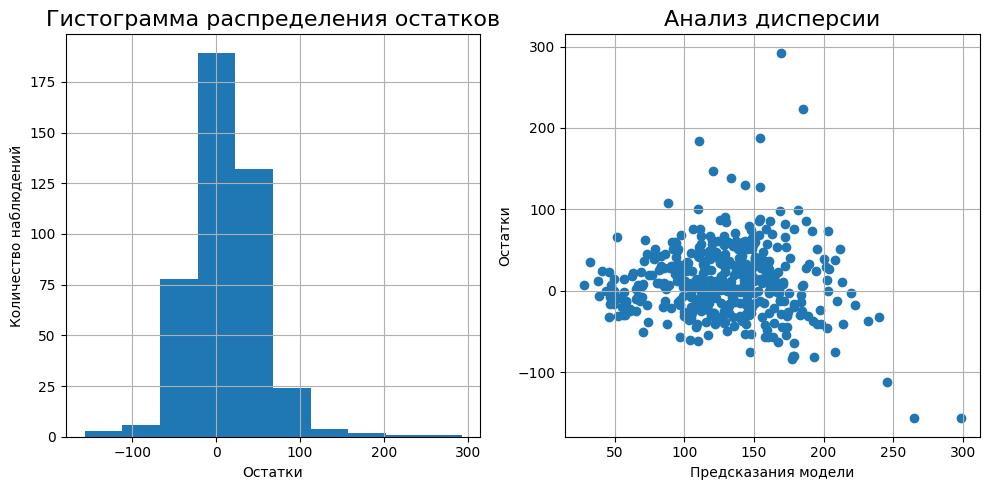

In [33]:
analyze_residuals(y_test, predictions)

Распределены остатки нормально. По дисперсии видно, что модель не улавливает значения в часы пик, занижая или завышая прогнозы, в периоды, когда подачи выше 100 авто.

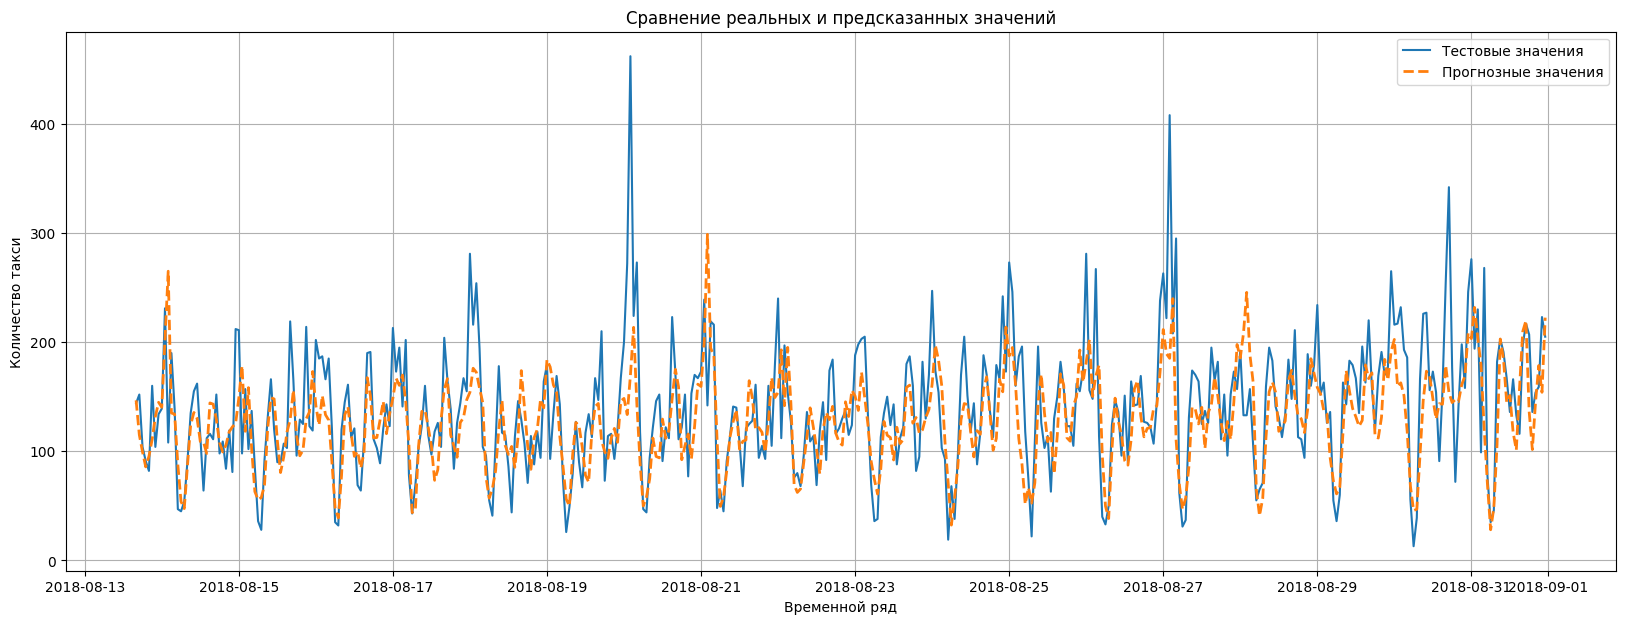

In [34]:
plt.figure(figsize=(20, 7))

plt.plot(y_test.index, y_test, label='Тестовые значения')

plt.plot(y_test.index, predictions, label='Прогнозные значения', linestyle='dashed', linewidth=2)

plt.title('Сравнение реальных и прогнозных значений')
plt.xlabel('Временной ряд')
plt.ylabel('Количество такси')
plt.title("Сравнение реальных и предсказанных значений")
plt.legend()
plt.grid()
plt.show()

**Вывод:**

Целью данного проекта является создание прогнозной модели для компании «Чётенькое такси» для предсказания количества машин, потребующихся в следующий час.

Для выподнения задачи был предоставлен датасет, представляющий из себя таблицу из 26496 наблюдений по двум признакам: даты - временной ряд с периодом в 10 минут и целевого признака - количества такси. Данные охватывают период с марта 2018 по август 2018 включительно. 

В ходе анализы были выявлена суточная сезонность с почти отсутствием заказов в ночные часы и максимальной нагрузкой в вечерние, недельная - рост количества заказов начиная с понедельника и имея два максимума - в пятницу и в воскресение. Помимо сезонности временной ряд содержит восходящий тренд на протяжении всего периода.

Тренд мешает работе прогнозных моделей, поэтому были предприняты операции для придания ряду стационарности:
+ логарифмирование признака для уменьшения разброса;
+ применение сдвига временного ряда.

Данные операции составляют главный механизм формирования входных признаков для улучшения качества модели: создание так называемых лагов с разным шагом на основе логарифма таргета. Количество шагов сдвига был подобран автоматически на моели линейной регрессии.

Для подбора модели обучения использовали ряд, состоящий из моделей: LineraRegression, Ridge, Lasso и ElasticNet. Наилучший результат продемонстрировала модель ElasticNet. Она продемонстрировала результат, вараженный в метрике RMSE = 46, который удовлетворяет нижнему порогу задачи.  

Однако, судя по анализу остатков модель, плохо справляется с пиками вызовов такси, занижая значения. Это видно и на графике сравнения тестовых и прогнозных значений.